In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
#

In [ ]:
# !cp '/content/drive/MyDrive/spectrograms.zip' .

In [ ]:
# !unzip -q spectrograms.zip
#

In [ ]:
# # !pip list
#

In [ ]:
# !rm -r /content/logs

In [ ]:
import keras.callbacks
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import math
import pandas as pd
import random
from tensorflow.keras import models, layers, callbacks, activations

import librosa
import librosa.display

import warnings

import pickle

AUTOTUNE = tf.data.AUTOTUNE

# tf.config.run_functions_eagerly(True)

In [ ]:
SAMPLE_RATE = 24000
FREQ_SIZE = 188
SECONDS = 4

N_MFCC = 100

BATCH_SIZE_TRAIN = 1
BATCH_SIZE_TEST = 1
BATCH_SIZE_VAL = 1
EPOCHS = 25

NUM_TRAIN = 10

STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE_TRAIN

NUM_LANGUAGES = 1
LANGUAGES = ['EN']

LOG_DIR = "/content/logs/model" + str(NUM_LANGUAGES) + "-"

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

LEARNING_RATE = 0.001

In [ ]:
BASE_DIR_EN = '/content/spectrograms/en/clips/'
TRAIN_PATH_EN = '/content/spectrograms/en/trainleft3.tsv'
TEST_PATH_EN = '/content/spectrograms/en/testleft3.tsv'
VAL_PATH_EN = '/content/spectrograms/en/valleft3.tsv'

NUM_TRAIN_EN = NUM_TRAIN
NUM_VAL_EN = 1
NUM_TEST_EN = 250

LABELS_EN = ['zero','one','two','three','four','five','six','seven','eight','nine','ten','Hey','yes','no','Firefox']
NUM_LABELS_EN = len(LABELS_EN)

In [ ]:
def padaudio(waveform):
    if (len(waveform) >= SAMPLE_RATE * SECONDS):
        return waveform
    else:
        return np.pad(waveform,(0,SAMPLE_RATE * SECONDS - len(waveform)),mode='constant', constant_values=(0,0))

# def processdata(file):
#     waveform,sample_rate = librosa.load(file, SAMPLE_RATE)
#     waveform = padaudio(waveform)
#     mfccs = librosa.feature.mfcc(waveform,sr=sample_rate,n_mfcc=N_MFCC)
#     mfccs = np.moveaxis(mfccs,1,0)
#     scaler = StandardScaler()
#     mfccs_scaled = scaler.fit_transform(mfccs)
#     return mfccs_scaled.reshape(mfccs_scaled.shape[0], mfccs_scaled.shape[1],1)

def processdata(file):
  filename = file.split(".")[0] + '.pkl'
  with open(filename,'rb') as f:
    spectrogram = pickle.load(f)

  return spectrogram

In [ ]:
def getlabel(onehot,labels):
    index = np.argmax(onehot)
    label = labels[index]
    return label

def getonehot(label,labels):
    onehot = np.array([1 if x == label else 0 for x in labels])
    return onehot

In [ ]:
def getdata(df,base_dir):
    df['fullpath'] = base_dir + df['path']
    inputs = df['fullpath'].tolist()
    labels = df['sentence'].tolist()
    x = np.array(inputs)
    y = np.array(labels)
    return x,y

In [ ]:
dftrainEN = pd.read_csv(TRAIN_PATH_EN, sep='\t', header=0)
dftrainEN.sort_values(by='length',ascending=False,inplace=True)
trainxEN,trainyEN, = getdata(dftrainEN.head(NUM_TRAIN_EN), BASE_DIR_EN)

dfvalEN = pd.read_csv(VAL_PATH_EN, sep='\t', header=0)
dfvalEN.sort_values(by='length',ascending=False,inplace=True)
valxEN,valyEN, = getdata(dfvalEN.head(NUM_VAL_EN), BASE_DIR_EN)

dftestEN = pd.read_csv(TEST_PATH_EN, sep='\t', header=0)
dftestEN.sort_values(by='length',ascending=False,inplace=True)
testxEN,testyEN, = getdata(dftestEN.head(NUM_TEST_EN), BASE_DIR_EN)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def maketraingenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(trainxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator

xtypes = tuple([tf.float32]*NUM_LANGUAGES)
ytypes = tuple([tf.int32]*NUM_LANGUAGES)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(NUM_LANGUAGES)])
yshapes = tuple([[15] for i in range(NUM_LANGUAGES)])
traingenshapes = (xshapes,yshapes)

In [ ]:
def makevalgenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(valxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator

In [ ]:
trainxs = [trainxEN,trainxFR]
trainys = [[trainyEN,LABELS_EN],[trainyFR,LABELS_FR]]

valxs = [valxEN,valxFR]
valys = [[valyEN,LABELS_EN],[valyFR,LABELS_FR]]

In [ ]:
# print(trainxEN[100])

In [ ]:
def maketestgenerator(testx,testy,labels):
    def testgenerator():
        for i in range(len(testx)):
            x = processdata(testx[i])
            y = getonehot(testy[i],labels)
            yield x,y
    return testgenerator

testgentypes = (tf.float32,tf.int32)
testgenshapes = ([FREQ_SIZE,N_MFCC,1],[15])

In [ ]:
traindataset = tf.data.Dataset.from_generator(maketraingenerator(trainxs,trainys),output_types=traingentypes,output_shapes=traingenshapes)
traindataset = traindataset.shuffle(NUM_TRAIN_EN)
traindataset = traindataset.batch(BATCH_SIZE_TRAIN)
traindataset = traindataset.repeat(-1)
traindataset = traindataset.cache().prefetch(AUTOTUNE)

valdataset = tf.data.Dataset.from_generator(makevalgenerator(valxs,valys),output_types=traingentypes,output_shapes=traingenshapes)
valdataset = valdataset.batch(BATCH_SIZE_VAL)
valdataset = valdataset.cache().prefetch(AUTOTUNE)

testdatasetEN = tf.data.Dataset.from_generator(maketestgenerator(testxEN,testyEN,LABELS_EN),output_types=testgentypes,output_shapes=testgenshapes)
testdatasetEN = testdatasetEN.batch(BATCH_SIZE_TEST)

In [ ]:
# print(trainxs)

In [ ]:
# traingen = maketraingenerator(trainxs,trainys)
# print(next(traingen()))

# print(traingentypes)
# print(traingenshapes)

In [ ]:
def languagelayers(num_labels,language):
        lang = models.Sequential([
        layers.Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation=activations.relu, name=language+'_Conv2D1'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D1'),
        # layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation=activations.relu, name=language+'_Conv2D2'),
        # layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name=language+'_MaxPool2D2'),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation=activations.relu, name=language+'_DenseLayer1'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation=activations.softmax, name=language+'_Output')
        ],
        name=language)

        return lang

Model: "Full_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 English_Input (InputLayer)     [(None, 188, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 French_Input (InputLayer)      [(None, 188, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 Shared_Layers (Sequential)     (None, 14, 7, 128)   258816      ['English_Input[0][0]',          
                                                                  'French_Input[0][0]']  

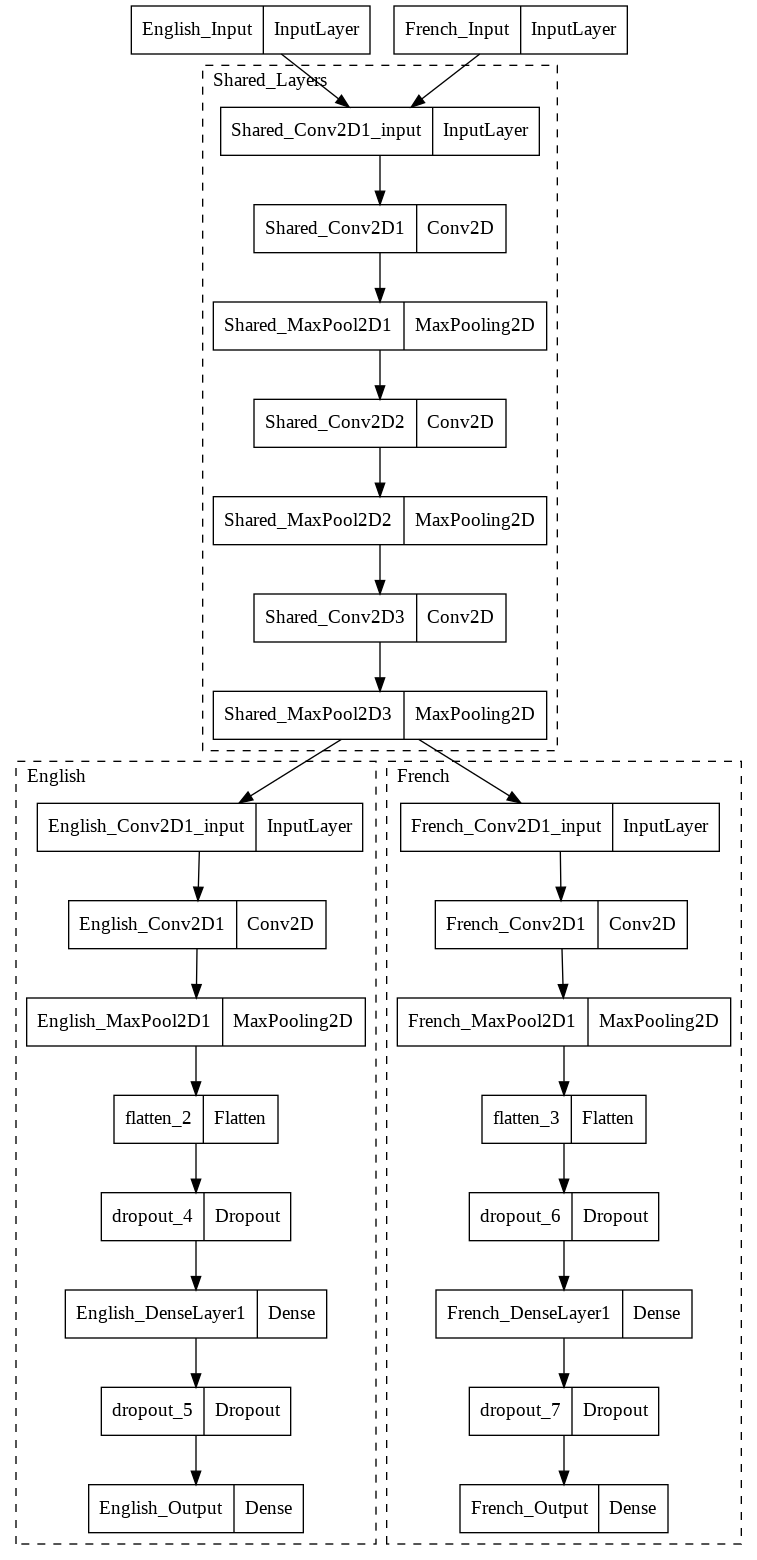

In [ ]:
inputEN = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='English_Input')
inputFR = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='French_Input')

shared = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(9,9), strides=(3,3), padding='same', activation=activations.relu, name='Shared_Conv2D1'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), name='Shared_MaxPool2D1'),
    layers.Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', activation=activations.relu, name='Shared_Conv2D2'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(1,1), name='Shared_MaxPool2D2'),
    layers.Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same', activation=activations.relu, name='Shared_Conv2D3'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(1,1), name='Shared_MaxPool2D3')
    ],
    name='Shared_Layers'
)

sharedLayersEN = shared(inputEN)
sharedLayersFR = shared(inputFR)

layersEN = languagelayers(NUM_LABELS_EN,'English')(sharedLayersEN)
layersFR = languagelayers(NUM_LABELS_FR,'French')(sharedLayersFR)


model = tf.keras.Model(
    inputs=[inputEN,inputFR],
    outputs=[layersEN,layersFR],
    name='Full_Model'
)


model.summary(expand_nested=True)
tf.keras.utils.plot_model(model, expand_nested=True)

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy(),tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [ ]:
RUN = '1'

training_callback = callbacks.TensorBoard(log_dir=LOG_DIR + RUN)
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# model.predict(testdatasetEN)

In [ ]:
history = model.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback,earlystopping_callback,reduce_lr_callback],
    verbose=1
)


Epoch 1/25
15/15 [==============================] - 43s 3s/step - loss: 5.4017 - English_loss: 2.6985 - French_loss: 2.7032 - English_Categorical_Accuracy: 0.1053 - English_AUC: 0.5491 - French_Categorical_Accuracy: 0.0733 - French_AUC: 0.5312 - val_loss: 5.3884 - val_English_loss: 2.6961 - val_French_loss: 2.6923 - val_English_Categorical_Accuracy: 0.0600 - val_English_AUC: 0.5196 - val_French_Categorical_Accuracy: 0.0400 - val_French_AUC: 0.4658 - lr: 0.0010
Epoch 2/25
15/15 [==============================] - 39s 3s/step - loss: 5.3483 - English_loss: 2.6745 - French_loss: 2.6738 - English_Categorical_Accuracy: 0.1133 - English_AUC: 0.5575 - French_Categorical_Accuracy: 0.0787 - French_AUC: 0.5470 - val_loss: 5.3631 - val_English_loss: 2.6856 - val_French_loss: 2.6775 - val_English_Categorical_Accuracy: 0.0600 - val_English_AUC: 0.5121 - val_French_Categorical_Accuracy: 0.0400 - val_French_AUC: 0.4972 - lr: 0.0010
Epoch 3/25
15/15 [==============================] - 39s 3s/step - loss

In [ ]:
history2 = model.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

In [ ]:
# modelEN = tf.keras.Model(
#     inputs=inputEN,
#     outputs=layersEN,
#     name='ENModel'
# )

# modelEN.compile(optimizer = tf.keras.optimizers.Adam(),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     metrics=tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'))

# modelEN.evaluate(testdatasetEN)

10/10 [==============================] - 0s 14ms/step - loss: 1.4433 - Categorical Accuracy: 0.6000


[1.4432828426361084, 0.6000000238418579]

In [ ]:
# def generator(N=10):
#     """
#     Returns tuple of (inputs,outputs) where
#     inputs  = (inp1,inp2,inp2)
#     outputs = (out1,out2)
#     """
#     dt=np.float32
#     for i in range(N):
#         inputs  = (np.random.rand(N,3,3,1).astype(dt),
#                    np.random.rand(N,3,3,1).astype(dt),
#                    np.random.rand(N,3,3,1).astype(dt))
#         outputs = (np.random.rand(N,3,3,1).astype(dt),
#                    np.random.rand(N,3,3,1).astype(dt))
#         yield inputs,outputs

# # Create dataset from generator
# types = ( (tf.float32,tf.float32,tf.float32),
#           (tf.float32,tf.float32) )
# shapes = (([None,3,3,1],[None,3,3,1],[None,3,3,1]),
#           ([None,3,3,1],[None,3,3,1]))
# data = tf.data.Dataset.from_generator(generator,
#                                       output_types=types,
#                                       output_shapes=shapes
#                                      )
# # Define a model
# inp1 = tf.keras.Input(shape=(3,3,1),name='inp1')
# inp2 = tf.keras.Input(shape=(3,3,1),name='inp2')
# inp3 = tf.keras.Input(shape=(3,3,1),name='inp3')
# out1 = tf.keras.layers.Conv2D(1,kernel_size=3,padding='same')(inp1)
# out2 = tf.keras.layers.Conv2D(1,kernel_size=3,padding='same')(inp2)
# model2 = tf.keras.Model(inputs=[inp1,inp2,inp3],outputs=[out1,out2])
# model2.compile(loss=['mse','mse'])
# # model2.summary()
# tf.keras.utils.plot_model(model2, expand_nested=True)
# # Train
# model2.fit(data)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs